## Projeto de Redes Sociais

In [1]:
import freeman as fm
import statsmodels.api as sm
import networkx as nx
import pylab

In [2]:
def proportion(g, n, m):
    return 1 / g.degree(n)

def local_effsize(g, n, m):
    s = 1
    for k in g.neighbors(n):
        if g.has_edge(k, m):
            s -= proportion(g, n, k)
    return s

def effsize(g, n):
    s = 0
    for m in g.neighbors(n):
        s += local_effsize(g, n, m)
    return s

In [13]:
cblol_g = fm.load('data/cblol.gml')
cblol_g.set_all_nodes(size=15, labpos='top right')
cblol_g.set_all_edges(color=(0, 0, 0, 0.5))
cblol_g.move('kamada_kawai')
cblol_g.draw()

<ipython-input-12-fc012f893ea2>:12: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



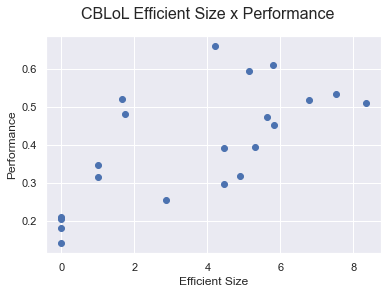

In [12]:
cblol_perf = []
cblol_eff = []
for n in cblol_g.nodes:
    cblol_perf.append(cblol_g.nodes[n]['perf'])
    cblol_eff.append(effsize(cblol_g, n))

ax = pylab.subplot(111)
ax.scatter(cblol_eff, cblol_perf)
pylab.xlabel('Efficient Size')
pylab.ylabel('Performance')
pylab.suptitle('CBLoL Efficient Size x Performance', fontsize=16)
ax.figure.show()

<ipython-input-7-7238787b96ab>:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



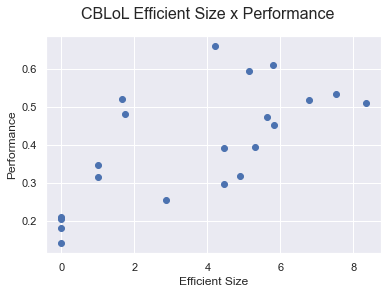

In [8]:
model = sm.OLS(cblol_perf, cblol_eff)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.812
Model:                            OLS   Adj. R-squared (uncentered):              0.803
Method:                 Least Squares   F-statistic:                              86.37
Date:                Sun, 22 Nov 2020   Prob (F-statistic):                    1.07e-08
Time:                        21:15:16   Log-Likelihood:                          5.6298
No. Observations:                  21   AIC:                                     -9.260
Df Residuals:                      20   BIC:                                     -8.215
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0856      0.009      9.294      0.000       0.066       0.105
==============================================================================
Omnibus:                        3.017   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                1.259
Skew:                           0.063   Prob(JB):                        0.533
Kurtosis:                       1.807   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
lck_g = fm.load('data/lck.gml')
lck_g.set_all_nodes(size=15, labpos='top right')
lck_g.set_all_edges(color=(0, 0, 0, 0.5))
lck_g.move('kamada_kawai')
lck_g.draw()

<ipython-input-17-b78548d27aad>:12: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



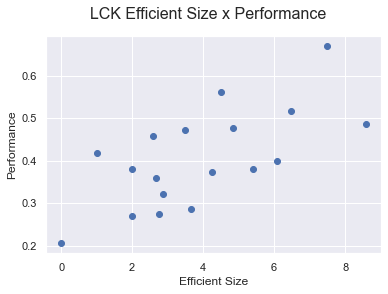

In [17]:
lck_perf = []
lck_eff = []
for n in lck_g.nodes:
    lck_perf.append(lck_g.nodes[n]['perf'])
    lck_eff.append(effsize(lck_g, n))

ax = pylab.subplot(111)
ax.scatter(lck_eff, lck_perf)
pylab.xlabel('Efficient Size')
pylab.ylabel('Performance')
pylab.suptitle('LCK Efficient Size x Performance', fontsize=16)
ax.figure.show()

In [18]:
model = sm.OLS(lck_perf, lck_eff)
result = model.fit()
result.summary()

C:\Users\lchen\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=18



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.863
Model:                            OLS   Adj. R-squared (uncentered):              0.855
Method:                 Least Squares   F-statistic:                              107.2
Date:                Sun, 22 Nov 2020   Prob (F-statistic):                    9.25e-09
Time:                        22:01:15   Log-Likelihood:                          7.9080
No. Observations:                  18   AIC:                                     -13.82
Df Residuals:                      17   BIC:                                     -12.93
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0872      0.008     10.356      0.000       0.069       0.105
==============================================================================
Omnibus:                        0.607   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.325
Skew:                          -0.314   Prob(JB):                        0.850
Kurtosis:                       2.802   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""